Let us look at how we can implement  text classification with Tensorflow  https://www.tensorflow.org/
<br>
TensorFlow is an end-to-end open source platform for machine learning. It has a comprehensive, flexible ecosystem of tools, libraries and community resources that lets researchers push the state-of-the-art in ML and developers easily build and deploy ML powered applications. 
<br>
The dataset is from the Tweet Sentiment Extraction challenge from Kaggle(https://www.kaggle.com/c/tweet-sentiment-extraction/overview)
<br>
We would implement  text classification using a simple neural network developed using Tensorflow  on tweet data to classify tweets as "positive","negative" or "neutral"

In [14]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers

from collections import Counter


import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


import pydot

In [15]:
print(tf.__version__)


2.1.0


In [16]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


Let us define methods to pre-process the tweets

In [17]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_url(text): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string


def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()



Let us pre-process the data

In [18]:
train_data= pd.read_csv("C:\\TweetSenitment\\train.csv")
train_data.dropna(axis = 0, how ='any',inplace=True) 
train_data['Num_words_text'] = train_data['text'].apply(lambda x:len(str(x).split())) 
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]
print('===========Train Data =========')
print(train_data['sentiment'].value_counts())
print(len(train_data))
print('==============================')


train_data['text'] = train_data['text'].apply(remove_emoji)
train_data['text'] = train_data['text'].apply(remove_url)
train_data['text'] = train_data['text'].apply(clean_text)


test_data= pd.read_csv("C:\\TweetSenitment\\test.csv")
test_data.dropna(axis = 0, how ='any',inplace=True) 
test_data['Num_words_text'] = test_data['text'].apply(lambda x:len(str(x).split())) 
mask = test_data['Num_words_text'] >2
test_data = test_data[mask]
print('===========Test Data =========')
print(test_data['sentiment'].value_counts())
print(len(test_data))
print('==============================')

test_data['text'] = test_data['text'].apply(remove_emoji)
test_data['text'] = test_data['text'].apply(remove_url)
test_data['text'] = test_data['text'].apply(clean_text)






===========Train Data =========
neutral     10704
positive     8375
negative     7673
Name: sentiment, dtype: int64
26752
===========Test Data =========
neutral     1376
positive    1075
negative     983
Name: sentiment, dtype: int64
3434


Let us split the training data into train and validation datasets
Let us convert our training,validation and test data into the format accepted by tensorflow

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['text'].tolist(), train_data['sentiment'].tolist(), test_size=0.33,stratify = train_data['sentiment'].tolist(), random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution: '+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution: '+ str(Counter(y_valid)))




x_train=np.asarray(X_train)
x_valid = np.array(X_valid)
x_test =np.asarray(test_data['text'].tolist())

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['sentiment'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))


Train data len:17923
Class distribution: Counter({'neutral': 7171, 'positive': 5611, 'negative': 5141})
Valid data len:8829
Class distribution: Counter({'neutral': 3533, 'positive': 2764, 'negative': 2532})


In [20]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])


['neutral', 'neutral', 'neutral', 'positive', 'negative', 'neutral', 'positive', 'negative', 'negative', 'neutral']
Text to number
[1 1 1 2 0 1 2 0 0 1]
Number to category
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [23]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==5:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==5:
        break
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==5:
        break  
    

======Train dataset ====
tf.Tensor(b'just getting additional free', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'also bored school third freelesson freistunde', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'playing society', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'luckyand wife loves', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(b'thats kinda mean dont think', shape=(), dtype=string) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
======Validation dataset ====
tf.Tensor(b'thought only with tags outside shirt', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'stillll listening paranoid starting civics homework jonas episode', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'just dropped biscuit', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), d

tf.Tensor(b'raid leader made drills practice switching', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'clang rocks youre using right anyways according comments apples dunno public', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'unlike cierra look like poop today whatevahh', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'enjoy hanami picnic cherry tree park hope weather stays nice', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(b'comp deleted half apps', shape=(), dtype=string) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'whin park swings victory mine right', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(b'well would seem that enter nine individual without ssnitin according apple hurray', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(b'because like

tf.Tensor(b'church bellss ringin adieugod bless german', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(b'still feel like craaaap like everyone earth needs know this have birdies', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'watching movies again great performance', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(b'watch spelling contest winner kavya shivshankar impressive performance even heared most words', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(b'probably this weather', shape=(), dtype=string) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'some relaxation much things list really that much', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'your message such twitter freak', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'wonder hate driving count

tf.Tensor(b'sniffle kids hubby just left work sydney weekend', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'house probably resembling your kind heaven maybe ciarans angels have moved with hence inability locate', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'good hear several peeps working tonight', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(b'hope', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(b'actually think more upset lost data cake mania pretty into game', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'booup sold', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'just star trek amazing seriously good entire cast excellent spock kirk especially want again', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(b'miss here', sh

tf.Tensor(b'indeed twitter where mate happening here enjoy hope arou', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(b'just want both youtaylor swift hayley williams have great lovely voice', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(b'watching photos room waiting ulise home', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'have been playing skate hours need actually skate late', shape=(), dtype=string) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'drive automatically ejecting supported discs cant boot from disc time applecare', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'omfg worst days ever', shape=(), dtype=string) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'love dreambears want best friend', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(b'rofl', shape=(), dtype

tf.Tensor(b'cant find hope didnt eaten anything last nighthe jumped deck just wont stay safe sigh', shape=(), dtype=string) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'poor baby girl poorly', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'whooo baby good luck', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(b'aaaww thats good know glad james doing great love guys kisses from venezuela', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(b'does real detroit weekly have websiteoh horror horror', shape=(), dtype=string) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'going line rest made some progress game over weekend like again', shape=(), dtype=string) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'omgod soooo tired dont think have energy film today', shape=(), dtype=string) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'min

tf.Tensor(b'will play quake3 3min', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'hope went well rooting both from comfortable world application formfillingin', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(b'need talk about something that happened today', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'just click without subscription needed vote tweet today best list', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(b'will miss least home right', shape=(), dtype=string) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'what those barrels made pass that barrel', shape=(), dtype=string) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(b'thanks adding', shape=(), dtype=string) tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor(b'cant wait watch next season heroes', shape=(), dtype=string) tf.Tensor([0. 0. 1.], sha

****
Source:https://www.tensorflow.org/tutorials/keras/text_classification_with_hub
<br>

One way to represent the text is to convert sentences into embeddings vectors. 
<br>
We can use a pre-trained text embedding as the first layer, which will have two advantages:
<br>
* we don't have to worry about text preprocessing,
* we can benefit from transfer learning.
<br>
For this example we will use a model from TensorFlow Hub called google/tf2-preview/gnews-swivel-20dim-with-oov/1.

There are three other models to test for the sake of this tutorial:

* google/tf2-preview/gnews-swivel-20dim-with-oov/1 - same as google/tf2-preview/gnews-swivel-20dim/1, but with 2.5% vocabulary converted to OOV buckets. This can help if vocabulary of the task and vocabulary of the model don't fully overlap.
* google/tf2-preview/nnlm-en-dim50/1 - A much larger model with ~1M vocabulary size and 50 dimensions.
* google/tf2-preview/nnlm-en-dim128/1 - Even larger model with ~1M vocabulary size and 128 dimensions.
****

In [12]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)


In [24]:
print(x_train[:1])
hub_layer(x_train[:1])

['just getting additional free']


<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[ 0.02252544, -1.102936  , -0.45312536,  1.1712923 , -0.9280152 ,
        -1.6799717 , -0.03097978, -0.04522766, -0.69689393, -0.3546787 ,
        -0.9819268 ,  1.3606595 , -0.7599448 ,  0.05979407, -0.71509284,
         0.48663723,  1.3430784 , -1.0147772 ,  0.13958323, -0.14541228]],
      dtype=float32)>

***
Let us create a simple Neural Network model  
<br>
<br>
Keras is a high-level API that's easier for ML beginners, as well as researchers.
It is integrated as part of Tensorflow 2.0
<br>
I am using the Sequential model
A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
Source :https://www.tensorflow.org/guide/keras/sequential_model
***

In [28]:


model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(3,activation='sigmoid'))



model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=["CategoricalAccuracy"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                389380    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 33        
Total params: 389,623
Trainable params: 389,623
Non-trainable params: 0
_________________________________________________________________


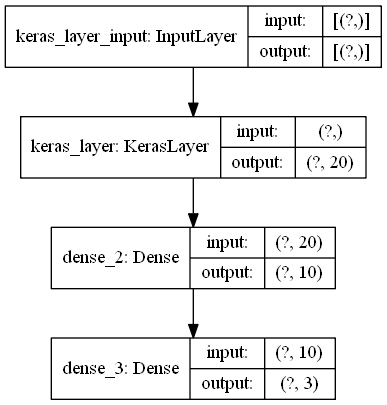

In [29]:
tf.keras.utils.plot_model(model, "simpleNN_model.png", show_shapes=True)

Let us train our model

In [30]:
epochs = 20

# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Train for 141 steps, validate for 69 steps
Epoch 1/20
141/141 [==============================] - 1s 8ms/step - loss: 1.0498 - CategoricalAccuracy: 0.4546 - val_loss: 0.9980 - val_CategoricalAccuracy: 0.5673
Epoch 2/20
141/141 [==============================] - 1s 5ms/step - loss: 0.9364 - CategoricalAccuracy: 0.6481 - val_loss: 0.9361 - val_CategoricalAccuracy: 0.6172
Epoch 3/20
141/141 [==============================] - 1s 5ms/step - loss: 0.8790 - CategoricalAccuracy: 0.6941 - val_loss: 0.9120 - val_CategoricalAccuracy: 0.6301
Epoch 4/20
141/141 [==============================] - 1s 5ms/step - loss: 0.8503 - CategoricalAccuracy: 0.7178 - val_loss: 0.9010 - val_CategoricalAccuracy: 0.6370
Epoch 5/20
141/141 [==============================] - 1s 5ms/step - loss: 0.8327 - CategoricalAccuracy: 0.7302 - val_loss: 0.8947 - val_CategoricalAccuracy: 0.6399
Epoch 6/20
141/141 [==============================] - 1s 5ms/step - loss: 0.8174 - CategoricalAccuracy: 0.7389 - val_loss: 0.8904 - val_C

In [31]:
history.historys

{'loss': [1.0501720816577071,
  0.9361798463572497,
  0.8799482641299641,
  0.8505051267178325,
  0.8320020652705921,
  0.8184366695238252,
  0.8074306060658205,
  0.7980653707193476,
  0.7899261863710678,
  0.7828051415077978,
  0.7762586956430425,
  0.7703170443674633,
  0.7649400953216119,
  0.7597407782303265,
  0.7549428299875031,
  0.7504769985426925,
  0.7462489665475786,
  0.7422547877410197,
  0.7386168563884064,
  0.735070059992257],
 'CategoricalAccuracy': [0.4545556,
  0.64805,
  0.69408023,
  0.7178486,
  0.7301791,
  0.7389388,
  0.7471405,
  0.75774145,
  0.7658316,
  0.7717458,
  0.7778832,
  0.7829604,
  0.7872566,
  0.7911622,
  0.79551417,
  0.7984712,
  0.80338115,
  0.8057803,
  0.808291,
  0.8106344],
 'val_loss': [0.9980366471884907,
  0.9360971589019333,
  0.9120150122089662,
  0.9010008495786915,
  0.8947092579758685,
  0.8903781676637954,
  0.8877766028694485,
  0.8862428777459739,
  0.8857016416563503,
  0.8853153413620548,
  0.8850273187609686,
  0.885751050

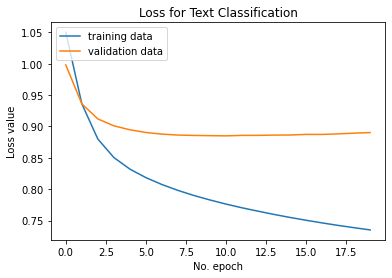

In [44]:
plt.plot(history.history['loss'], label='training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


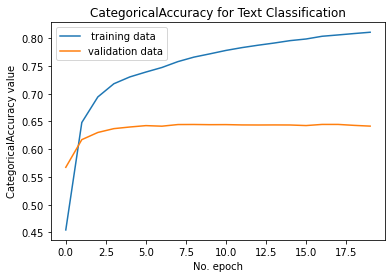

In [46]:


plt.plot(history.history['CategoricalAccuracy'], label=' training data')
plt.plot(history.history['val_CategoricalAccuracy'], label='validation data')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


***
Let us try Dropout and kernel regularizer to reduce overfitting of the previous model

***
***
Dropout
<br>

https://www.tensorflow.org/api_docs/python/tf/nn/dropout
<br>
Dropout is useful for regularizing DNN models. Inputs elements are randomly set to zero (and the other elements are rescaled). This encourages each node to be independently useful, as it cannot rely on the output of other nodes.
<br>
More precisely: With probability rate elements of x are set to 0. The remaining elements are scaled up by 1.0 / (1 - rate), so that the expected value is preserved.
<br>
***
***
Kernel Regularizer
<br>
https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
<br>
Regularizers allow you to apply penalties on layer parameters or layer activity during optimization. These penalties are summed into the loss function that the network optimizes.
<br>
tf.keras.regularizers.L1(0.3)  # L1 Regularization Penalty
<br>
tf.keras.regularizers.L2(0.1)  # L2 Regularization Penalty
<br>
tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)  # L1 + L2 penalties
<br>
***

In [49]:


model1 = tf.keras.Sequential()
model1.add(hub_layer)
model1.add(tf.keras.layers.Dropout(0.5))
model1.add(tf.keras.layers.Dense(10, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model1.add(tf.keras.layers.Dropout(0.5))
model1.add(tf.keras.layers.Dense(3,activation='sigmoid',kernel_regularizer=regularizers.l2(0.05)))



model1.summary()
model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=["CategoricalAccuracy"])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                389380    
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_9 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 33        
Total params: 389,623
Trainable params: 389,623
Non-trainable params: 0
_________________________________________________________________


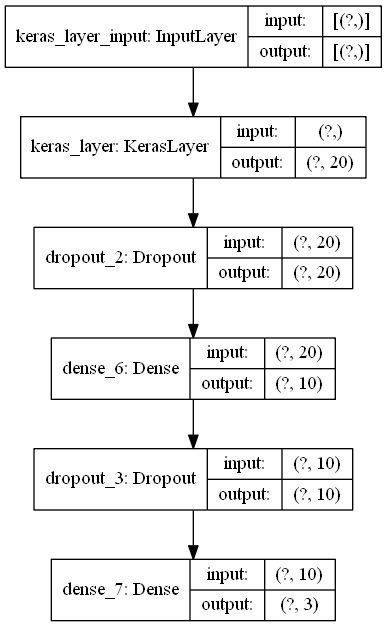

In [38]:
tf.keras.utils.plot_model(model1, "multi_input_and_output_model.png", show_shapes=True)

Let us train our modified model

In [50]:
epochs = 60

# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history1 = model1.fit(train_ds.shuffle(1000).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Train for 141 steps, validate for 69 steps
Epoch 1/60
141/141 [==============================] - 1s 9ms/step - loss: 1.7796 - CategoricalAccuracy: 0.4154 - val_loss: 1.5006 - val_CategoricalAccuracy: 0.5933
Epoch 2/60
141/141 [==============================] - 1s 5ms/step - loss: 1.3473 - CategoricalAccuracy: 0.5521 - val_loss: 1.2302 - val_CategoricalAccuracy: 0.6367
Epoch 3/60
141/141 [==============================] - 1s 5ms/step - loss: 1.1556 - CategoricalAccuracy: 0.6254 - val_loss: 1.1208 - val_CategoricalAccuracy: 0.6394
Epoch 4/60
141/141 [==============================] - 1s 5ms/step - loss: 1.0785 - CategoricalAccuracy: 0.6479 - val_loss: 1.0788 - val_CategoricalAccuracy: 0.6376
Epoch 5/60
141/141 [==============================] - 1s 5ms/step - loss: 1.0511 - CategoricalAccuracy: 0.6579 - val_loss: 1.0620 - val_CategoricalAccuracy: 0.6363
Epoch 6/60
141/141 [==============================] - 1s 5ms/step - loss: 1.0396 - CategoricalAccuracy: 0.6601 - val_loss: 1.0547 - val_C

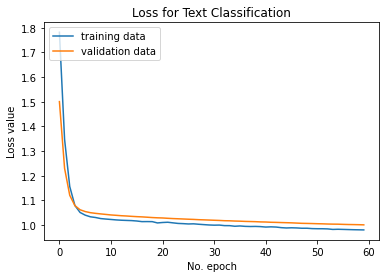

In [51]:
plt.plot(history1.history['loss'], label='training data')
plt.plot(history1.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

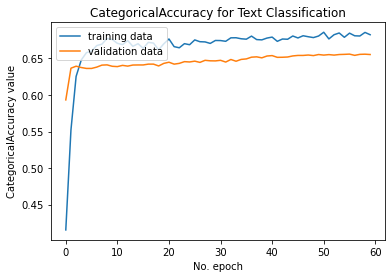

In [52]:
plt.plot(history1.history['CategoricalAccuracy'], label='training data')
plt.plot(history1.history['val_CategoricalAccuracy'], label='validation data')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

Let us evaluate our model on test data

In [53]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model1.evaluate(x_test,test_labels)
print("test loss, test acc:", results)


# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = model1.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)


Evaluate on test data
3434/3434 [==============================] - 1s 179us/sample - loss: 0.9969 - CategoricalAccuracy: 0.6628
test loss, test acc: [0.9969230151898513, 0.6627839]
Generate predictions for all samples
[[0.29772028 0.78765696 0.2419032 ]
 [0.04800559 0.27351108 0.93228984]
 [0.7996621  0.5566111  0.06950387]
 ...
 [0.55647314 0.7198958  0.12195881]
 [0.05773554 0.3459463  0.89993477]
 [0.04614305 0.2593145  0.9378081 ]]


In [20]:
print(predict_results)


[1 2 0 ... 0 2 2]


In [54]:
test_data['pred_sentiment']= predict_results
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == 0),'negative',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '1'),'neutral',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '2'),'positive',test_data.pred_sentiment)

In [55]:
test_data.head(20)

,textID,text,sentiment,Num_words_text,pred_sentiment
0,f87dea47db,last session,neutral,6,neutral
1,96d74cb729,shanghai also really exciting precisely skyscr...,positive,15,positive
2,eee518ae67,recession veronique branquinho quit company su...,negative,13,negative
4,33987a8ee5,like,positive,5,neutral
5,726e501993,thats great weee visitors,positive,4,positive
6,261932614e,think everyone hates here,negative,8,negative
7,afa11da83f,soooooo wish could school myspace completely b...,negative,13,neutral
8,e64208b4ef,within short time last clue them,neutral,12,neutral
9,37bcad24ca,what alright havent done anything leaving soon...,neutral,18,neutral
10,24c92644a4,bike holdshould have known that argh total bummer,negative,12,neutral


In [56]:
from sklearn.metrics import classification_report
labels = ['positive', 'negative','neutral']
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

    positive       0.80      0.65      0.72      1075
    negative       0.75      0.47      0.58       983
     neutral       0.57      0.81      0.67      1376

    accuracy                           0.66      3434
   macro avg       0.71      0.64      0.66      3434
weighted avg       0.70      0.66      0.66      3434



Let us save our model

In [24]:
model1.save('C:\\TweetSenitment\\savedTFMode\\tf_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: C:\TweetSenitment\savedTFMode\tf_model\assets


INFO:tensorflow:Assets written to: C:\TweetSenitment\savedTFMode\tf_model\assets


Let us reload our saved model and test it with test data

In [25]:
new_model = tf.keras.models.load_model('C:\\TweetSenitment\\savedTFMode\\tf_model')
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                389380    
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                525       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 78        
Total params: 389,983
Trainable params: 389,983
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = new_model.evaluate(x_test,test_labels)
print("test loss, test acc:", results)


# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)


Evaluate on test data
3434/3434 [==============================] - 0s 90us/sample - loss: 0.8893 - CategoricalAccuracy: 0.6607
test loss, test acc: [0.8893121269183861, 0.6607455]
Generate predictions for all samples
[[1.3014337e-01 9.9239808e-01 1.3068183e-02]
 [2.9145231e-04 2.5040274e-03 9.9996376e-01]
 [9.9972683e-01 1.6152790e-02 1.3134786e-03]
 ...
 [9.8893529e-01 5.1912415e-01 9.8424661e-04]
 [8.3680643e-05 2.8981483e-02 9.9983788e-01]
 [2.2150717e-04 2.1312148e-03 9.9997330e-01]]


In [28]:
test_data['pred_sentiment']= predict_results
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == 0),'negative',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '1'),'neutral',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '2'),'positive',test_data.pred_sentiment)

In [29]:
labels = ['positive', 'negative','neutral']
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

    positive       0.75      0.71      0.73      1075
    negative       0.65      0.60      0.62       983
     neutral       0.61      0.67      0.64      1376

    accuracy                           0.66      3434
   macro avg       0.67      0.66      0.66      3434
weighted avg       0.66      0.66      0.66      3434

